In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
local_path = os.path.abspath('')
sys.path.append(local_path)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from functions import plotgenerator as pg
from model import *
from simulations import Simulator
from estimation import SMD

## See how input input data is interpolated

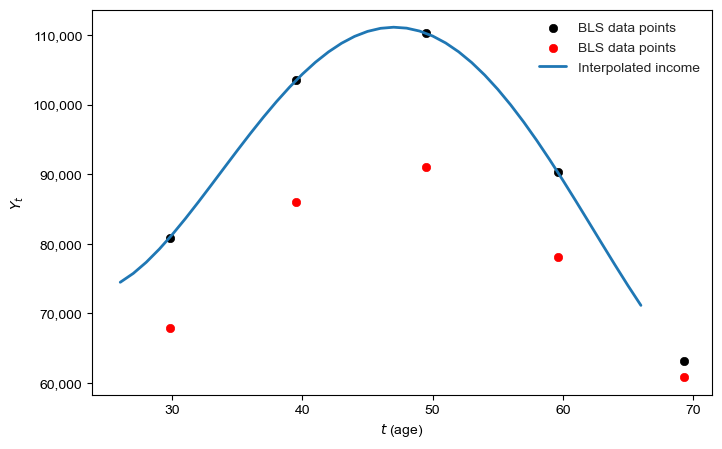

In [3]:
# Setup
model_data = gp_model() 
# Solve the model
model_data.solve_model()
# Simulate the model
sim_data = Simulator(model_data.par, model_data.sol).main()

# Plot the simulated data
fig = pg.PlotFigure(figsize=(8,5),fontname=None)
fig.add_plot(x=list(model_data.income_data.keys()),y=list(model_data.income_data.values()),marker='o',color='black',label='BLS data points',xlabel=f"$t$ (age)",ylabel=f"$Y_t$")
fig.add_plot(x=list(model_data.consumption_data.keys()),y=list(model_data.consumption_data.values()),marker='o',color='red',label='BLS data points')
fig.add_plot(x=model_data.grid_age,y=model_data.Ybar,linestyle='-',label='Interpolated income')
fig.add_legend()
fig.set_number_format('y','{x:,.0f}')
# fig.save_figure(f'{local_path}/output/income_data.png')
fig.show()

### plotting Income shifter

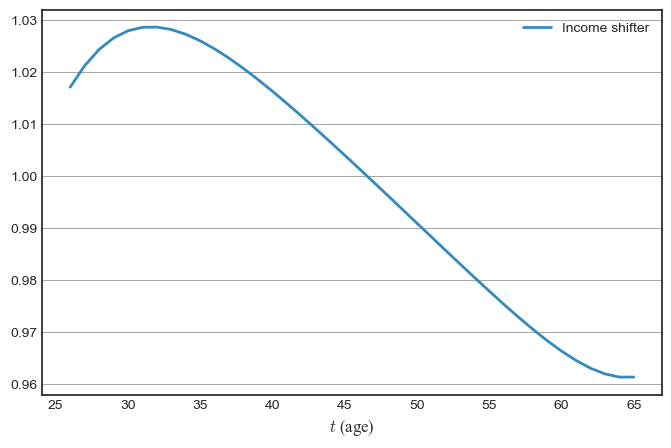

In [4]:
fig = pg.PlotFigure(figsize=(8,5),fontname='Times New Roman')
fig.add_plot(model_data.grid_age[:-1],model_data.par.G, label=f"Income shifter", linestyle='-',axis='y1')
fig.set_xlabel(f"$t$ (age)")
fig.add_legend()
fig.add_gridlines(axis='y')
fig.save_figure(f'{local_path}/output/income_shifter.png')
fig.show()

# Solution to the model

In [5]:
def solve_model(par_dict):
    model = gp_model(**par_dict)
    model.solve_model()
    return model

model_init_sol = solve_model({'share':1})


### plotting the results

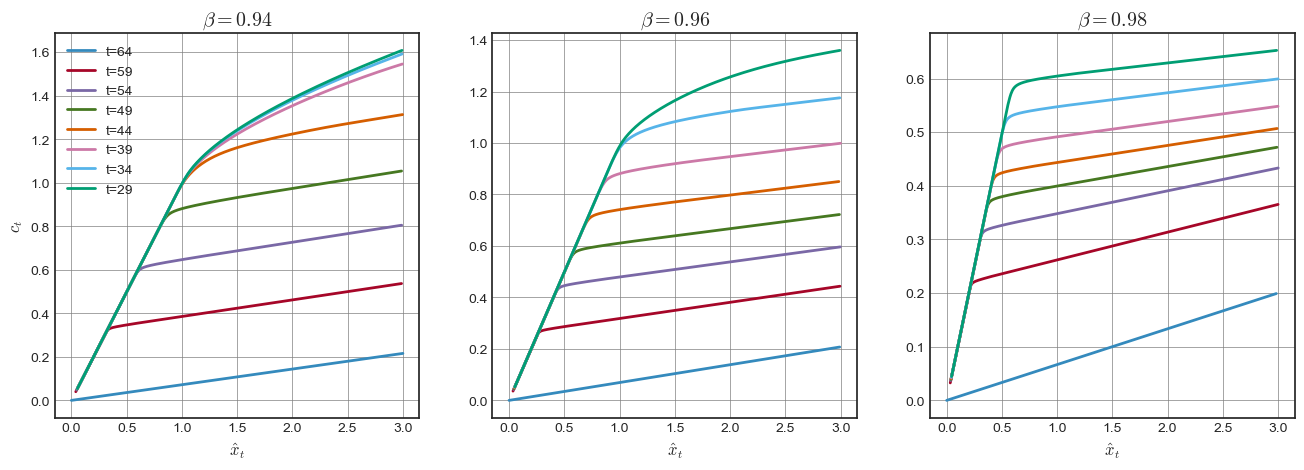

In [6]:
consumer = 0
rhos = [{'beta':0.94},{'beta':0.96},{'beta':0.98}]
fig = pg.PlotFigure(figsize=(16,5),fontname='Arial',rows=1,cols=len(rhos))
for i, par in enumerate(rhos):
    model = solve_model(par)
    # Print consumption function
    fig.change_ax(i)
    for t in range(model.par.Tr_N-1,model.par.t0_N-1,-5):
        criteria = np.where(model.sol.x[:,t,consumer] <= 3, True, False)
        fig.add_plot(model.sol.x[criteria,t,consumer],model.sol.c[criteria,t,consumer], label=f"t={25+t}", linestyle='-')
    if i == 0: fig.set_ylabel(f"$c_t$"); fig.add_legend();
    fig.set_title(f"$\\beta={par['beta']}$")
    fig.set_xlabel("$\hat{x}_t$")
    fig.add_gridlines(axis='both')

# fig.save_figure(f'{local_path}/output/egm_consumption.png')
fig.show()

### simulate how results look like

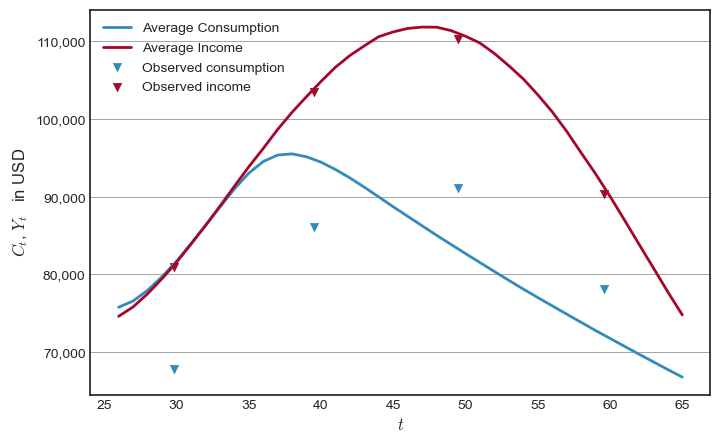

In [7]:
# s
sim = Simulator(model_init_sol.par, model_init_sol.sol).main()

obs_age = list(model_init_sol.income_data.keys())[:-1]
obs_income = list(model_init_sol.income_data.values())[:-1]
obs_consump = list(model_init_sol.consumption_data.values())[:-1]
# Plot simulation of the solution
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_init_sol.par.t0,model_init_sol.par.Tr)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig.add_plot(obs_age,obs_consump,label='Observed consumption', marker='v',axis='y1')
fig.add_plot(obs_age,obs_income,label='Observed income', marker='v',axis='y1')
fig.set_ylabel(f"$C_t$, $Y_t$   in USD")
fig.set_xlabel(f"$t$")
fig.set_number_format('y','{x:,.0f}')
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/simulation_of_solution.png')
fig.show()

##### Decompose savings 

In [8]:
model_lc = gp_model(**{'sigma_eta': 0.0, 'sigma_mu':0.0,'pi':0,'xmin':-10.0})

# retirement rule
model_lc.main_setup()

# Solve the Life-cycle model
model_lc.solve_model()

# Simulate the Life-cycle model
sim_lc = Simulator(model_lc.par, model_lc.sol).main()

In [ ]:
# Decomposition
consumer = 0
S_lc = np.mean(sim_lc.S[1:,:,consumer],axis=1)
W_lc = np.mean((sim_lc.P*sim_lc.a)[1:,:,consumer], axis=1)
S = np.mean(sim.S[1:,:,consumer],axis=1)
W = np.mean((sim.P*sim.a)[1:,:,consumer], axis=1)
S_b  = S - S_lc 
W_b = W - W_lc

In [ ]:
# Print consumption function
fig = pg.PlotFigure(figsize=(16,6),fontname='Arial',rows=1,cols=2)
x = range(0+model_init_sol.par.t0,len(S)+model_init_sol.par.t0)
fig.add_plot(x,S, label=f"Total", linestyle='-',axis='y1')
fig.add_plot(x,S_b, label=f"Bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,S_lc, label=f"Lifecycle", linestyle='-',axis='y1')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel(f"$Savings$")
fig.set_xlabel(f"$t$")
fig.add_legend()
fig.change_ax(1)
fig.add_plot(x,W, label=f"Total wealth", linestyle='-',axis='y1')
fig.add_plot(x,W_b, label=f"Wealth bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,W_lc, label=f"Wealth lifecycle", linestyle='-',axis='y1')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel(f"$Wealth$")
fig.set_xlabel(f"$t$")
# fig.save_figure(f'{local_path}/output/savings_decomposition.png')
fig.show()


# Estimation based on random data

### Data generation

In [ ]:
# Setup params
beta = 0.95
rho = 0.45
model_dgp = gp_model(**{'beta':beta,'rho':rho})

# Solve the model
model_dgp.solve_model()

dgp_par = [model_dgp.par.beta, model_dgp.par.rho]
# 
sim_dgp = Simulator(model_dgp.par, model_dgp.sol).main()
input_data = np.log(sim_dgp.C_avg)


In [ ]:
weight_mat_inv =  np.eye(input_data.size)   # The identity matrix and I^-1=I #np.diag(sim_dgp.C_var)
est = SMD(model=model_init_sol,simulator=Simulator, mom_data=input_data)

### grid search - and plot the objective function for different values

In [ ]:
est.beta_grid = np.arange(0.9,0.96,0.01)
est.rho_grid = np.arange(0.45,0.5,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [ ]:
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=None,W=weight_mat_inv, grid=False)

In [ ]:
print(f'estimated values using grid method {np.around(est.est,4)} and true parameters {dgp_par}, with objective function value {est.est_out.fun:.2f}')

In [ ]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

# Estimation using data from BLS
For data look at the very top

In [ ]:
# Setup
model_real = gp_model()

# input the data
real_data = model_real.Cbar[:-1] # Cbar has one more element than the grid_age

In [ ]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = SMD(model=model_real,simulator=Simulator, mom_data=real_data)
est_real.age_groups = False

In [ ]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=None,W=weight_mat_inv,grid=False)

In [ ]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')

In [ ]:
phi = ['r','gamma1','pi','sigma_eta','sigma_mu']
theta = ['beta','rho']
sens_mes = est_real.sensitivity(theta=theta, est_par=est_real.est, W=weight_mat_inv, phi_st=phi, step=1.0e-10)
for i, est_par in enumerate(theta):
    for j, cal_par in enumerate(phi):
        print(f"Sensitivity of {est_par} to {cal_par} is {sens_mes[i,j]:.3f}")

In [ ]:
# Obtain the optimal parameters
rho_opt = est_real.est[1]
beta_opt = est_real.est[0]
print(f'Optimal beta: {beta_opt}, Optimal rho: {rho_opt}')
# setup the model with the optimal parameters
model_fit = gp_model(**{'beta':beta_opt,'rho':rho_opt})
# solve model
model_fit.solve_model()

# 
sim_fit = Simulator(model_fit.par, model_fit.sol)
sim_fit = sim_fit.main()

In [ ]:
# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(model_real.grid_age[:-1], np.exp(model_real.Cbar[:-1]), label=f"Data", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.C_avg), label=f"Fitted values", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.Y_avg), label=f"Income", linestyle='-')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.add_gridlines(axis='y')
fig.set_number_format('y','{x:,.0f}')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/simulated_method_plot.png')
fig.show()

# Extension
Imagine two types of households with different timepreference, $\beta$
#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

#### Description of the types
Type I households have a higher time preference, $\beta^I > \beta^{II}$, and thus consume more in the present.


In [ ]:
# Setup params
type1_beta = 0.96 # high beta type -- C1
type2_beta = 0.9  # low  beta type -- C2
share = 0.4 # share of type 1
rho = 0.45 # risk aversion parameter
dgp_par_ext = [type1_beta,type2_beta,rho,share]

model_types = gp_model(**{'beta':type1_beta,'beta2':type2_beta,'share':share,'rho':rho,})
# Solve the model
model_types.solve_model()
# Simulate the model
sim_types = Simulator(model_types.par, model_types.sol).main()

In [ ]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,sim_types.Y_avg, label=f"Income", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg_type1, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_types.C_avg_type2, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [ ]:
weight_mat_inv = np.eye(sim_types.C_avg.shape[0])   # The identity matrix and I^-1=I
est_ext = SMD(model=model_types,simulator=Simulator, mom_data=np.log(sim_types.C_avg))

In [ ]:
constraint = lambda x: x[0] - x[1]
est_ext.estimate(theta0=[0.91,0.9,0.4,0.2],est_par=['beta','beta2','rho','share'],W=weight_mat_inv,bounds=[(0.01,0.99),(0.01,0.99),(0,10),(0,1)],constraint=constraint, grid=False)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {np.around(est_ext.est,4)}, while true parameters are {dgp_par_ext}, with objective function value {est_ext.est_out.fun:.2f}')
else:
    print(f'optimization failed')

In [ ]:
# simulate the model with the estimated parameters
model_fit_ext = gp_model(**{'beta':est_ext.est[0],'beta2':est_ext.est[1],'rho':est_ext.est[2],'share':est_ext.est[3]})
model_fit_ext.solve_model()
sim_fit_ext = Simulator(model_fit_ext.par, model_fit_ext.sol).main()

# plot the simulated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,sim_types.C_avg, label=f"Agg (DGP)", linestyle='-',color='black',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg, label=f"Agg (Estimated)", linestyle='--',color='black',axis='y1')

fig.add_plot(x,sim_types.C_avg_type1, label=f"Type I", linestyle='-',color='grey',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg_type1, linestyle='--',color='grey',axis='y1')

fig.add_plot(x,sim_types.C_avg_type2, label=f"Type II", linestyle='-',color='red',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg_type2, linestyle='--',color='red',axis='y1')


fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [ ]:
est_ext = SMD(model=model_types,simulator=Simulator, mom_data=real_data)
constraint = lambda x: x[0] - x[1]
est_ext.estimate(theta0=[0.975,0.925,0.4,0.5],est_par=['beta','beta2','rho','share'],W=weight_mat_inv,bounds=[(0.01,0.99),(0.01,0.99),(0,10),(0,1)],constraint=constraint, grid=False)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {np.around(est_ext.est,4)}')
else:
    print(f'optimization failed')

In [ ]:
# simulate the model with the estimated parameters
model_fit_ext = gp_model(**{'beta':est_ext.est[0],'beta2':est_ext.est[1],'rho':est_ext.est[2],'share':est_ext.est[3]})
model_fit_ext.solve_model()
sim_fit_ext = Simulator(model_fit_ext.par, model_fit_ext.sol).main()

# plot the simulated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(model_types.par.t0,model_types.par.Tr)
fig.add_plot(x,model_data.Ybar[:-1], label=f"Income Input", linestyle='-',axis='y1')
fig.add_plot(x,np.exp(real_data), label=f"Consumption input", linestyle='-',axis='y1')
fig.add_plot(x,sim_fit.C_avg, label=f"Baseline", linestyle='--',color='lightgrey',axis='y1')
fig.add_plot(x,sim_fit_ext.C_avg, label=f"Extented", linestyle='--',color='grey',axis='y1')
fig.add_gridlines(axis='y')
fig.set_number_format('y','{x:,.0f}')
fig.set_ylabel("$C_t^{agg}$")
fig.set_xlabel("$t$")
fig.add_legend()
fig.save_figure(f'{local_path}/output/extended_model_fit.png')
fig.show()
